In [1]:
import logging

import atlite

logging.basicConfig(level=logging.INFO)

import io
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import xarray as xr
from atlite.gis import ExclusionContainer, shape_availability
from shapely.geometry import Polygon

In [237]:
import platform
import shutil
import subprocess

In [2]:
aggregated_regions = [
    # "AT",
    # "DE",
    # "BE",
    # "BG",
    # "CH",
    # "CZ",
    # "DE",
    "DK",
    # "EE",
    # "ES",
    # "FI",
    # "FR",
    # "UK",
    # "GR",
    # "HR",
    # "HU",
    # "IE",
    # "IT",
    # "LT",
    # "LU",
    # "LV",
    # "NL",
    "NO",
    # "PL",
    # "PT",
    # "RO",
    # "SE",
    # "SI",
    # "SK",
]

In [3]:
desired_regions = aggregated_regions

In [7]:
euroshape = gpd.read_file("NUTS_RG_60M_2021_4326.geojson")
europe = (euroshape.replace({"EL": "GR"})
          .rename(columns={"id": "index"})
          .loc[:, ["index", "geometry"]]
          .sort_values("index")
          .set_index("index")
          .drop(["AL", "IS", "CY", "MT", "ME", "MK", "NO0B1", "NO0B2", "RS", "TR", "LI"])
          .loc[desired_regions]
)
europe

,geometry
index,
DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
NO,"MULTIPOLYGON (((28.89670 69.04260, 29.15370 69..."


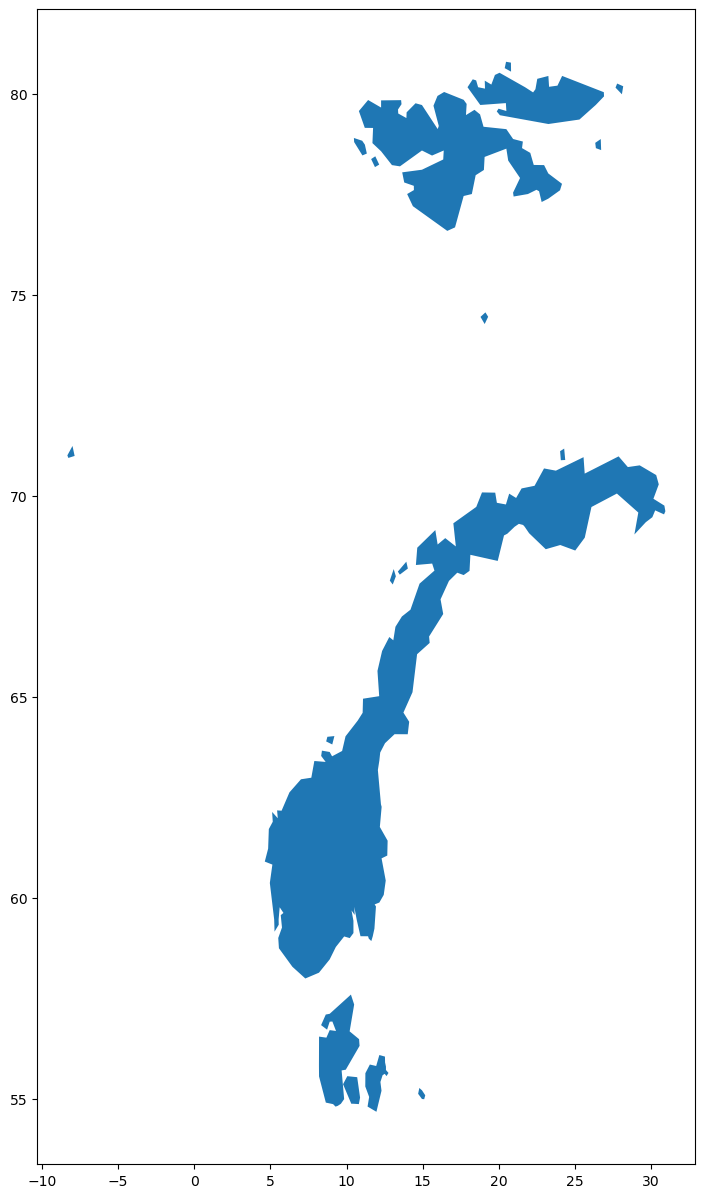

In [8]:
# The year for which to calculate the weather data:
year = 2010
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 81
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)
europe.plot(figsize=(15, 15));

In [9]:
weatherdata = f"europe_{str(year)}.nc"

In [10]:
cutout = atlite.Cutout(path=weatherdata)

In [11]:
cutout

<Cutout "europe_2010">
 x = -13.00 ⟷ 45.00, dx = 0.25
 y = 32.00 ⟷ 82.00, dy = 0.25
 time = 2010-01-01 ⟷ 2010-12-31, dt = H
 module = ['gebco', 'era5']
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [ ]:
#cutout.preapre()

In [13]:
europe = europe.sort_index()
europe

,geometry
index,
DK,"MULTIPOLYGON (((15.09400 54.99620, 14.94800 55..."
NO,"MULTIPOLYGON (((29.15370 69.58800, 27.74720 70..."


In [86]:
fn = pd.read_csv("EIA_hydro_generation_1995_2000_2014.csv")
fn

,International_data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,http://www.eia.gov/beta/international/data/bro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Mar 01 2017 17:25:47 GMT+0100 (CET),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Source: U.S. Energy Information Administration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1995.000,2000,2001,2002,2003,2004,2005,2006,2007,2008.000000,2009.000000,2010.00000,2011.000,2012.000,2013.000,2014.000
4,NaN,Electricity,Billion Kwh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Generation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Renewables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Hydroelectricity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Albania,Billion Kwh,NaN,4.5,3.5,3.5,5.1,5.4,5.319,4.951,2.76,3.759000,5.201000,7.67300,4.036,4.725,6.959,4.726
9,NaN,Austria,Billion Kwh,36.700,41,40,40,33,36,36.31,35.48,36.732,37.969000,40.487000,37.97900,33.901,43.376,41.595,40.592


In [87]:
eia_hydro_gen = (pd.read_csv("EIA_hydro_generation_1995_2000_2014.csv", 
            skiprows=4, index_col=1, na_values=[" ", "--"])
            .drop(["Unnamed: 0", "Unnamed: 2"], axis=1)
            .dropna(how="all")
)
eia_hydro_gen

,1995,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Albania,NaN,4.500000,3.500000,3.500000,5.10000,5.400000,5.319000,4.951000,2.760000,3.759000,5.201000,7.67300,4.036,4.725,6.959,4.726
Austria,36.700,41.000000,40.000000,40.000000,33.00000,36.000000,36.310000,35.480000,36.732000,37.969000,40.487000,37.97900,33.901,43.376,41.595,40.592
Belgium,0.340,0.500000,0.400000,0.400000,0.20000,0.300000,0.285000,0.355000,0.385000,0.406000,0.325000,0.30900,0.194,0.353,0.376,0.271
Bosnia and Herzegovina,NaN,5.000000,5.100000,5.200000,4.50000,5.900000,5.938000,5.798000,3.961000,4.818000,6.177000,7.94600,4.343,4.173,7.164,5.876
Bulgaria,2.290,2.600000,1.700000,2.200000,3.00000,3.100000,4.294000,4.196000,2.845000,2.796000,3.435000,5.00600,2.888,3.194,4.039,4.559
Croatia,5.210,5.800000,6.500000,5.300000,4.80000,6.900000,6.270000,5.940000,4.194000,5.164000,6.663000,9.03500,4.983,4.789,8.536,8.917
Czech Republic,1.980,1.700000,2.000000,2.500000,1.40000,2.000000,2.356000,2.525000,2.068000,2.004000,2.405000,2.76100,1.943,2.108,2.707,1.890
Denmark,0.030,0.030000,0.028000,0.032000,0.02100,0.027000,0.023000,0.023000,0.028000,0.026000,0.019000,0.02100,0.017,0.017,0.013,0.015
Estonia,0.002,0.005000,0.007000,0.006000,0.01300,0.022000,0.022000,0.014000,0.021000,0.028000,0.032000,0.02700,0.030,0.042,0.026,0.027
Faroe Islands,NaN,0.075262,0.075195,0.095535,0.08483,0.093443,0.097986,0.099934,0.103407,0.094921,0.091482,0.06676,0.092,0.099,0.091,0.121


In [88]:
# AT the moment three types of data is ready: desired region shapefile, weather data,
# historical electricity generation by hydro plants
import pycountry

In [89]:
# Attention: Some none values are coming
countries_iso2c = [
    pycountry.countries.get(name=country).alpha_2
    if pycountry.countries.get(name=country) is not None
    else None 
    for country in eia_hydro_gen.index.values
]


In [96]:
countries_iso2c
countries_iso2c[6] = "CZ" 
countries_iso2c [18] = "KV"
countries_iso2c[22] = "MK"
countries_iso2c[35] = "TR"
countries_iso2c

['AL',
 'AT',
 'BE',
 'BA',
 'BG',
 'HR',
 'CZ',
 'DK',
 'EE',
 'FO',
 'FI',
 'FR',
 'DE',
 'GR',
 'HU',
 'IS',
 'IE',
 'IT',
 'KV',
 'LV',
 'LT',
 'LU',
 'MK',
 'ME',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SK',
 'SI',
 'ES',
 'SE',
 'CH',
 'TR',
 'GB']

In [97]:
eia_hydro_gen.index = pd.Index(countries_iso2c, name="countries")
eia_hydro_gen


,1995,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
countries,,,,,,,,,,,,,,,,
AL,NaN,4.500000,3.500000,3.500000,5.10000,5.400000,5.319000,4.951000,2.760000,3.759000,5.201000,7.67300,4.036,4.725,6.959,4.726
AT,36.700,41.000000,40.000000,40.000000,33.00000,36.000000,36.310000,35.480000,36.732000,37.969000,40.487000,37.97900,33.901,43.376,41.595,40.592
BE,0.340,0.500000,0.400000,0.400000,0.20000,0.300000,0.285000,0.355000,0.385000,0.406000,0.325000,0.30900,0.194,0.353,0.376,0.271
BA,NaN,5.000000,5.100000,5.200000,4.50000,5.900000,5.938000,5.798000,3.961000,4.818000,6.177000,7.94600,4.343,4.173,7.164,5.876
BG,2.290,2.600000,1.700000,2.200000,3.00000,3.100000,4.294000,4.196000,2.845000,2.796000,3.435000,5.00600,2.888,3.194,4.039,4.559
HR,5.210,5.800000,6.500000,5.300000,4.80000,6.900000,6.270000,5.940000,4.194000,5.164000,6.663000,9.03500,4.983,4.789,8.536,8.917
CZ,1.980,1.700000,2.000000,2.500000,1.40000,2.000000,2.356000,2.525000,2.068000,2.004000,2.405000,2.76100,1.943,2.108,2.707,1.890
DK,0.030,0.030000,0.028000,0.032000,0.02100,0.027000,0.023000,0.023000,0.028000,0.026000,0.019000,0.02100,0.017,0.017,0.013,0.015
EE,0.002,0.005000,0.007000,0.006000,0.01300,0.022000,0.022000,0.014000,0.021000,0.028000,0.032000,0.02700,0.030,0.042,0.026,0.027


In [ ]:
#eia_hydro_gen.rename(index={"Kosovo": "KV"}, inplace=True)
eia_hydro_gen

In [100]:
eia_hydro_gen = eia_hydro_gen.T

In [101]:
eia_hydro_gen = eia_hydro_gen*1e6
eia_hydro_gen

countries,AL,AT,BE,BA,BG,HR,CZ,DK,EE,FO,...,PT,RO,RS,SK,SI,ES,SE,CH,TR,GB
1995,NaN,36700000.0,340000.0,NaN,2290000.0,5210000.0,1980000.0,30000.0,2000.0,NaN,...,8260000.0,16526000.0,NaN,4831000.0,3187000.0,22881000.0,67421000.0,34817000.0,NaN,4790000.0
2000,4500000.0,41000000.0,500000.0,5000000.0,2600000.0,5800000.0,1700000.0,30000.0,5000.0,75262.0,...,11000000.0,15000000.0,NaN,4600000.0,3800000.0,29000000.0,78000000.0,36000000.0,31000000.0,5000000.0
2001,3500000.0,40000000.0,400000.0,5100000.0,1700000.0,6500000.0,2000000.0,28000.0,7000.0,75195.0,...,14000000.0,15000000.0,NaN,4900000.0,3700000.0,41000000.0,78000000.0,41000000.0,24000000.0,4000000.0
2002,3500000.0,40000000.0,400000.0,5200000.0,2200000.0,5300000.0,2500000.0,32000.0,6000.0,95535.0,...,7700000.0,16000000.0,NaN,5200000.0,3300000.0,23000000.0,66000000.0,35000000.0,33000000.0,4700000.0
2003,5100000.0,33000000.0,200000.0,4500000.0,3000000.0,4800000.0,1400000.0,21000.0,13000.0,84830.0,...,16000000.0,13000000.0,NaN,3400000.0,2900000.0,41000000.0,53000000.0,34000000.0,35000000.0,3200000.0
2004,5400000.0,36000000.0,300000.0,5900000.0,3100000.0,6900000.0,2000000.0,27000.0,22000.0,93443.0,...,9800000.0,16000000.0,NaN,4100000.0,4000000.0,31000000.0,60000000.0,33000000.0,46000000.0,4800000.0
2005,5319000.0,36310000.0,285000.0,5938000.0,4294000.0,6270000.0,2356000.0,23000.0,22000.0,97986.0,...,4684000.0,20005000.0,NaN,4592000.0,3426000.0,18209000.0,72075000.0,30914000.0,39165000.0,4873000.0
2006,4951000.0,35480000.0,355000.0,5798000.0,4196000.0,5940000.0,2525000.0,23000.0,14000.0,99934.0,...,10892000.0,18172000.0,10855000.0,4355000.0,3555000.0,25699000.0,61106000.0,30649000.0,43802000.0,4547000.0
2007,2760000.0,36732000.0,385000.0,3961000.0,2845000.0,4194000.0,2068000.0,28000.0,21000.0,103407.0,...,9991000.0,15806000.0,9937000.0,4406000.0,3233000.0,27036000.0,65497000.0,34898000.0,35492000.0,5026000.0
2008,3759000.0,37969000.0,406000.0,4818000.0,2796000.0,5164000.0,2004000.0,26000.0,28000.0,94921.0,...,6730000.0,17023000.0,9468000.0,4000000.0,3978000.0,23130000.0,68378000.0,35676000.0,32937000.0,5094000.0


In [102]:
europe.index

Index(['DK', 'NO'], dtype='object', name='index')

In [104]:
eia_stats = eia_hydro_gen.reindex(columns=europe.index)
eia_stats

index,DK,NO
1995,30000.0,120315000.0
2000,30000.0,140000000.0
2001,28000.0,119000000.0
2002,32000.0,128000000.0
2003,21000.0,104000000.0
2004,27000.0,108000000.0
2005,23000.0,134331000.0
2006,23000.0,118175000.0
2007,28000.0,132319000.0
2008,26000.0,137654000.0


In [105]:
eia_stats.columns

Index(['DK', 'NO'], dtype='object', name='index')

In [106]:
europe2 = europe.copy()

In [109]:
europe2.index.name = "countries"
europe2

,geometry
countries,
DK,"MULTIPOLYGON (((15.09400 54.99620, 14.94800 55..."
NO,"MULTIPOLYGON (((29.15370 69.58800, 27.74720 70..."


In [110]:
inflow = cutout.runoff(
    shapes = europe2,
    smooth = True,
    lower_threshold_quantile = True,
    normalize_using_yearly = eia_stats
)


INFO:atlite.convert:Convert and aggregate 'runoff'.


[########################################] | 100% Completed | 82.64 s


In [112]:
df_installed_cap = pd.read_csv(
    "hydro_installed_cap.tsv", 
    sep="\t",
    usecols=["Year", "AreaName", "MapCode", "ProductionType", "highRES_Europe"],
)
df_installed_cap

,Year,AreaName,MapCode,ProductionType,highRES_Europe
0,2015,Austria,AT,Hydro Run-of-river and poundage,5542.700
1,2015,Austria,AT,Hydro Water Reservoir,2964.900
2,2015,Austria,AT,Hydro Pumped Storage,2971.100
3,2015,Belgium,BE,Hydro Run-of-river and poundage,114.560
4,2015,Belgium,BE,Hydro Pumped Storage,1308.000
...,...,...,...,...,...
108,2015,Sweden,SE,Hydro Run-of-river and poundage,0.000
109,2015,Sweden,SE,Hydro Water Reservoir,16.184
110,2015,Switzerland,CH,Hydro Run-of-river and poundage,4645.570
111,2015,Switzerland,CH,Hydro Water Reservoir,8208.060


In [113]:
# Excluded pumped storage
# Three hydro production types data at country level: run-of-river and poundage
# Hydro water reservoir, pumped hydro storage
df_installed_cap = df_installed_cap.loc[
    df_installed_cap["ProductionType"] != "Hydro Pumped Storage"]

df_installed_cap

,Year,AreaName,MapCode,ProductionType,highRES_Europe
0,2015,Austria,AT,Hydro Run-of-river and poundage,5542.700
1,2015,Austria,AT,Hydro Water Reservoir,2964.900
3,2015,Belgium,BE,Hydro Run-of-river and poundage,114.560
5,2015,Belgium,BE,Hydro Water Reservoir,0.000
6,2015,Bulgaria,BG,Hydro Water Reservoir,1566.000
...,...,...,...,...,...
105,2015,Spain,ES,Hydro Run-of-river and poundage,1085.400
108,2015,Sweden,SE,Hydro Run-of-river and poundage,0.000
109,2015,Sweden,SE,Hydro Water Reservoir,16.184
110,2015,Switzerland,CH,Hydro Run-of-river and poundage,4645.570


In [116]:
df_installed_cap.MapCode.unique()

array(['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE',
       'UK', 'GR', 'HU', 'IE', 'IT', 'IS', 'LV', 'LT', 'LU', 'MT', 'NL',
       'NO34', 'NO50', 'NO18', 'NO54', 'NO03', 'NO30', 'NO38', 'NO42',
       'NO11', 'NO46', 'NO15', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES',
       'SE', 'CH'], dtype=object)

In [186]:
df_cap_shares = (
    df_installed_cap.loc[:, ["MapCode", "ProductionType", "highRES_Europe"]]
    .set_index(["ProductionType", "MapCode"])
    .unstack("ProductionType")
    .loc[:, "highRES_Europe"]
    .assign(
        Hydro=lambda x: x["Hydro Run-of-river and poundage"]
        + x["Hydro Water Reservoir"],
        share_ror=lambda x: x["Hydro Run-of-river and poundage"] / x["Hydro"],
        share_res=lambda x: x["Hydro Water Reservoir"] / x["Hydro"],
    )
    .loc[:, ["share_ror", "share_res"]]
)
df_cap_shares

ProductionType,share_ror,share_res
MapCode,,
AT,0.651500,0.348500
BE,1.000000,0.000000
BG,0.000000,1.000000
CH,0.361421,0.638579
CY,NaN,NaN
CZ,0.403670,0.596330
DE,0.865820,0.134180
DK,1.000000,0.000000
EE,1.000000,0.000000


In [128]:
inflow

<xarray.DataArray (time: 8760, countries: 2)>
array([[3.41852820e+00, 8.96155653e+03],
       [3.41915860e+00, 8.95906601e+03],
       [3.42066346e+00, 8.95690659e+03],
       ...,
       [4.05714273e+00, 8.42716753e+03],
       [4.06167700e+00, 8.42293887e+03],
       [4.06724214e+00, 8.41865686e+03]])
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
  * countries  (countries) object 'DK' 'NO'
Attributes:
    units:    MW

In [144]:
inflow_res = (
    inflow.assign_coords(time=range(0, len(inflow.time)))
    .assign_coords(technology="HydroRes")
    .expand_dims("technology")
    .stack(final=["time", "countries", "technology"])
    .round(2)
    .to_pandas()
    .reset_index()
)
inflow_res

,time,countries,technology,0
0,0,DK,HydroRes,3.42
1,0,NO,HydroRes,8961.56
2,1,DK,HydroRes,3.42
3,1,NO,HydroRes,8959.07
4,2,DK,HydroRes,3.42
...,...,...,...,...
17515,8757,NO,HydroRes,8427.17
17516,8758,DK,HydroRes,4.06
17517,8758,NO,HydroRes,8422.94
17518,8759,DK,HydroRes,4.07


In [150]:
inflow_res.columns = inflow_res.columns.map(str)
inflow_res = inflow_res.rename(columns={"0": "value"})
inflow_res

,time,countries,technology,value
0,0,DK,HydroRes,3.42
1,0,NO,HydroRes,8961.56
2,1,DK,HydroRes,3.42
3,1,NO,HydroRes,8959.07
4,2,DK,HydroRes,3.42
...,...,...,...,...
17515,8757,NO,HydroRes,8427.17
17516,8758,DK,HydroRes,4.06
17517,8758,NO,HydroRes,8422.94
17518,8759,DK,HydroRes,4.07


In [151]:
inflow_res.countries.unique()

array(['DK', 'NO'], dtype=object)

In [154]:
df_cap_shares.loc[inflow_res.countries.unique(), :]

ProductionType,share_ror,share_res
MapCode,,
DK,1.000000,0.000000
NO,0.242642,0.757358


In [164]:
#Saving the hourly inflow of hydro_res only
(
    inflow_res.set_index(["countries", "time", "technology"])
    .mul(
    df_cap_shares.rename(columns={"share_res": "value"}),
    axis="index",
    level="countries",
)
.drop(columns={"share_ror"})
.reset_index()
.set_index("time")
.round(0)
.to_csv("hydroresinf1.csv")
)



In [168]:
df_installed_cap

,Year,AreaName,MapCode,ProductionType,highRES_Europe
0,2015,Austria,AT,Hydro Run-of-river and poundage,5542.700
1,2015,Austria,AT,Hydro Water Reservoir,2964.900
3,2015,Belgium,BE,Hydro Run-of-river and poundage,114.560
5,2015,Belgium,BE,Hydro Water Reservoir,0.000
6,2015,Bulgaria,BG,Hydro Water Reservoir,1566.000
...,...,...,...,...,...
105,2015,Spain,ES,Hydro Run-of-river and poundage,1085.400
108,2015,Sweden,SE,Hydro Run-of-river and poundage,0.000
109,2015,Sweden,SE,Hydro Water Reservoir,16.184
110,2015,Switzerland,CH,Hydro Run-of-river and poundage,4645.570


In [172]:
df_installed_ror = (
    df_installed_cap.loc[
        df_installed_cap["ProductionType"] == "Hydro Run-of-river and poundage"
    ]
    .set_index("MapCode")
    .drop(columns={"Year", "AreaName", "ProductionType"})
    .loc[:, "highRES_Europe"]
)
df_installed_ror

MapCode
AT       5542.7000
BE        114.5600
BG          0.0000
HR        421.0000
CY          0.0000
CZ        440.0000
DK          9.0000
EE          8.0000
FI       3264.0000
FR      10314.1000
DE       4775.0000
UK       1874.5600
GR          0.0000
HU         28.7400
IE        216.0000
IT      10719.0000
IS         24.6000
LV       1537.0000
LT        128.0000
LU         25.0000
MT          0.0000
NL         38.0000
NO34     1418.5080
NO50     1018.2563
NO18      870.2057
NO54      429.8470
NO03        4.7000
NO30     2305.1224
NO38      414.4202
NO42     1015.1930
NO11     1112.6346
NO46     4463.0181
NO15      716.7155
NO       7552.0000
PL        377.8400
PT       2979.0000
RO       2670.0000
SK       1203.0000
SI       1053.0000
ES       1085.4000
SE          0.0000
CH       4645.5700
Name: highRES_Europe, dtype: float64

In [176]:
df_installed_ror = df_installed_ror[df_installed_ror > 0]

In [177]:
df_installed_ror

MapCode
AT       5542.7000
BE        114.5600
HR        421.0000
CZ        440.0000
DK          9.0000
EE          8.0000
FI       3264.0000
FR      10314.1000
DE       4775.0000
UK       1874.5600
HU         28.7400
IE        216.0000
IT      10719.0000
IS         24.6000
LV       1537.0000
LT        128.0000
LU         25.0000
NL         38.0000
NO34     1418.5080
NO50     1018.2563
NO18      870.2057
NO54      429.8470
NO03        4.7000
NO30     2305.1224
NO38      414.4202
NO42     1015.1930
NO11     1112.6346
NO46     4463.0181
NO15      716.7155
NO       7552.0000
PL        377.8400
PT       2979.0000
RO       2670.0000
SK       1203.0000
SI       1053.0000
ES       1085.4000
CH       4645.5700
Name: highRES_Europe, dtype: float64

In [195]:
ror_capfac = (
    inflow.to_pandas()
    .T.stack()
    .div(df_installed_ror, axis="index", level="countries")
)
ror_capfac

countries  time               
DK         2010-01-01 00:00:00    0.379836
           2010-01-01 01:00:00    0.379907
           2010-01-01 02:00:00    0.380074
           2010-01-01 03:00:00    0.380185
           2010-01-01 04:00:00    0.380252
                                    ...   
NO         2010-12-31 19:00:00    1.116952
           2010-12-31 20:00:00    1.116429
           2010-12-31 21:00:00    1.115886
           2010-12-31 22:00:00    1.115326
           2010-12-31 23:00:00    1.114759
Length: 17520, dtype: float64

In [196]:
ror_capfac = ror_capfac.dropna()
ror_capfac

countries  time               
DK         2010-01-01 00:00:00    0.379836
           2010-01-01 01:00:00    0.379907
           2010-01-01 02:00:00    0.380074
           2010-01-01 03:00:00    0.380185
           2010-01-01 04:00:00    0.380252
                                    ...   
NO         2010-12-31 19:00:00    1.116952
           2010-12-31 20:00:00    1.116429
           2010-12-31 21:00:00    1.115886
           2010-12-31 22:00:00    1.115326
           2010-12-31 23:00:00    1.114759
Length: 17520, dtype: float64

In [199]:
ror_capfac = ror_capfac.where(ror_capfac <= 1, 1)
ror_capfac

countries  time               
DK         2010-01-01 00:00:00    0.379836
           2010-01-01 01:00:00    0.379907
           2010-01-01 02:00:00    0.380074
           2010-01-01 03:00:00    0.380185
           2010-01-01 04:00:00    0.380252
                                    ...   
NO         2010-12-31 19:00:00    1.000000
           2010-12-31 20:00:00    1.000000
           2010-12-31 21:00:00    1.000000
           2010-12-31 22:00:00    1.000000
           2010-12-31 23:00:00    1.000000
Length: 17520, dtype: float64

<Axes: xlabel='countries,time'>

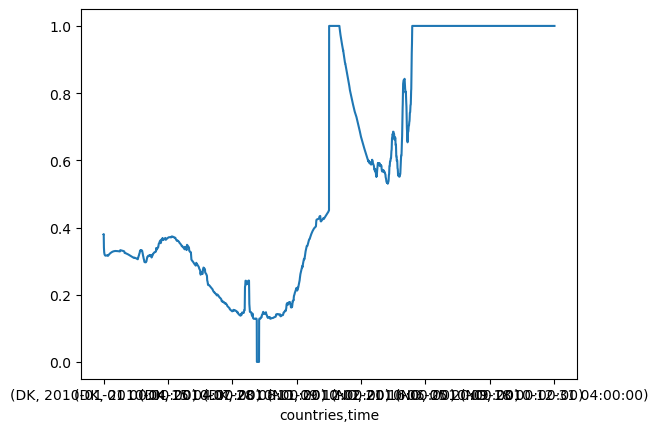

In [200]:
ror_capfac.plot()

In [203]:
capacity_factor_hydro_ror = ror_capfac.to_xarray().rename({"countries": "index"})
capacity_factor_hydro_ror

<xarray.DataArray (index: 2, time: 8760)>
array([[0.37983647, 0.37990651, 0.38007372, ..., 0.45079364, 0.45129744,
        0.45191579],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])
Coordinates:
  * index    (index) object 'DK' 'NO'
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00

In [207]:
capacity_factor_hydro_ror.name = "HydroRoR"

In [209]:
capacity_factor_hydro_ror.time.size

8760

In [215]:
capacity_factor_hydro_ror.assign_coords(
    technology=lambda x: x.name, time=range(0, capacity_factor_hydro_ror.time.size)
).expand_dims("technology").stack(final=["time", "technology", "index"]).round(2).to_pandas().to_csv(
    "hydrororcapfac", header=False
)

In [216]:
cutout.grid

,x,y,geometry
0,-13.00,32.0,"POLYGON ((-12.87500 31.87500, -12.87500 32.125..."
1,-12.75,32.0,"POLYGON ((-12.62500 31.87500, -12.62500 32.125..."
2,-12.50,32.0,"POLYGON ((-12.37500 31.87500, -12.37500 32.125..."
3,-12.25,32.0,"POLYGON ((-12.12500 31.87500, -12.12500 32.125..."
4,-12.00,32.0,"POLYGON ((-11.87500 31.87500, -11.87500 32.125..."
...,...,...,...
46828,44.00,82.0,"POLYGON ((44.12500 81.87500, 44.12500 82.12500..."
46829,44.25,82.0,"POLYGON ((44.37500 81.87500, 44.37500 82.12500..."
46830,44.50,82.0,"POLYGON ((44.62500 81.87500, 44.62500 82.12500..."
46831,44.75,82.0,"POLYGON ((44.87500 81.87500, 44.87500 82.12500..."


In [220]:
with open("zones.csv", "r") as file:
    list_of_lines = file.readlines()
list_of_lines
list_of_lines.pop(0)
list_of_lines


['DK\n', 'NO\n']

In [221]:
newlines = []
for line in list_of_lines:
    newlines.extend(["HydroRoR." + line[:-1] + "." + line[:-1] + " inf\n"])
newlines

['HydroRoR.DK.DK inf\n', 'HydroRoR.NO.NO inf\n']

In [231]:
newlines = sorted(newlines)
df = pd.DataFrame(newlines)
df.to_csv('areashydro.csv', index=False, header=False)

In [241]:
vre_areas_unsorted = 'vre_areas_unsorted.txt'
with open ('vre_areas_unsorted.txt', "wb") as wfd:
    for f in [
        "areashydro.csv",
    ]:
        with open (f, "rb") as fd:
            shutil.copyfileobj(fd, wfd)

In [243]:
print(vre_areas_unsorted)



vre_areas_unsorted.txt
